In [1]:

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from PIL import Image

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        """
        standard ResNet style convolutional block
        """
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        """
        process and downscale the image feature maps
        """
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        """
        process and upscale the image feature maps
        """
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things  
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1 * n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(
                2 * n_feat, 2 * n_feat, 7, 7
            ),  # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = -1 * (1 - context_mask)  # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out



def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(
            self.device
        )

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w=0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(
            device
        )  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 12).to(
            device
        )  # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample / c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # makes second half of batch context free

        x_i_store = []  # keep track of generated steps in case want to plot something
        print(self.n_T)
        for i in range(self.n_T, 0, -1):
            print(f"sampling timestep {i}", end="\r")
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1, 1, 1)

            # double batch
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


c:\Users\19941\anaconda3\envs\gm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

CLASSES = [
    "airplane",
    "bus",
    "car",
    "fish",
    "guitar",
    "laptop",
    "pizza",
    "sea turtle",
    "star",
    "t-shirt",
    "The Eiffel Tower",
    "yoga",
]

class sub12Dataset(Dataset):
    """
    Each data is a tuple (image, label).
    Image is of size [1, h, w], and label is an integer from 0 to 11, each representing a class.
    """

    def _read_image(self, path):
        """
        Given an image path, returns a grey image with shape [1, h, w].
        """
        grey_image = Image.open(path).convert("L")
        grey_image = grey_image.resize((28, 28))
        grey_np = np.array(grey_image)[None, :, :] / 255.0
        # grey_np[grey_np < 0.99] = 0.0
        grey_np = 1.0-grey_np
        grey_np = grey_np*5.0
        grey_np[grey_np>=0.99]=1.0
        return grey_np.astype(np.float32)

    def __init__(self, root_dir):
        metadata = []
        from tqdm import tqdm

        for i, class_name in enumerate(CLASSES):
            class_dir = os.path.join(root_dir, class_name)
            print(f"Loading {class_name}")
            for file_name in tqdm(os.listdir(class_dir)):
                metadata.append((os.path.join(class_dir, file_name), i))
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        path, label = self.metadata[idx]
        return (torch.from_numpy(self._read_image(path)), label)
    
# hardcoding these here
n_epoch = 50
batch_size = 256
n_T = 100  
device = "cuda:0"
n_classes = 12
n_feat = 128  # 128 ok, 256 better (but slower)
lrate = 2e-4
save_model = False
save_dir = "./data/diffusion_outputs_12/"
ws_test = [0.0, 0.5, 2.0, 5.0]  # strength of generative guidance

dataset = sub12Dataset("subclass12")



dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
    )



Loading airplane


100%|██████████| 5001/5001 [00:00<00:00, 521706.07it/s]


Loading bus


100%|██████████| 5001/5001 [00:00<00:00, 585979.28it/s]


Loading car


100%|██████████| 5001/5001 [00:00<00:00, 361569.21it/s]


Loading fish


100%|██████████| 5001/5001 [00:00<00:00, 677991.93it/s]


Loading guitar


100%|██████████| 5001/5001 [00:00<00:00, 662028.60it/s]


Loading laptop


100%|██████████| 5001/5001 [00:00<00:00, 770486.13it/s]


Loading pizza


100%|██████████| 5001/5001 [00:00<00:00, 348874.23it/s]


Loading sea turtle


100%|██████████| 5001/5001 [00:00<00:00, 717020.38it/s]


Loading star


100%|██████████| 5001/5001 [00:00<00:00, 684474.28it/s]


Loading t-shirt


100%|██████████| 5001/5001 [00:00<00:00, 748624.66it/s]


Loading The Eiffel Tower


100%|██████████| 5001/5001 [00:00<00:00, 357965.67it/s]


Loading yoga


100%|██████████| 5001/5001 [00:00<00:00, 682780.97it/s]


torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([11,  7,  1,  7, 10,  9, 10,  7,  8,  3,  8,  4,  4,  3,  5,  7,  1,  7,
        11,  8,  2,  3,  4,  8,  2,  1, 10,  1,  3,  0,  7,  9, 11,  4,  5,  3,
         9, 11,  1,  7,  3,  3, 11,  8,  6,  3,  9,  3,  8,  1,  3,  2,  4,  1,
         4,  5,  8,  9,  1,  5,  2,  6,  6, 11,  8,  0,  1, 10,  1,  8,  5, 11,
         2,  2,  1,  5, 11,  3,  0,  9,  7,  8,  3,  2, 10,  4,  7,  0,  6,  4,
         2,  7,  7,  6, 11,  4,  8,  0,  7,  5, 11,  9,  9, 11, 11,  4,  6,  9,
         6,  4,  6,  2, 10, 10, 11, 11,  4,  4,  0, 11, 10,  2, 10,  9,  2,  9,
         6,  8,  6,  8, 11,  0,  8,  2,  7,  1,  5,  0,  7,  0,  9,  9, 11,  7,
         5, 10,  9,  2,  2,  2,  2,  6,  1, 11,  5,  8,  3,  7,  3,  0,  5,  0,
         1, 10,  2,  7,  6,  1,  1,  1, 11,  6,  9,  1,  4,  5,  4,  6,  0,  2,
         8,  9,  4,  9,  7,  5,  5, 11,  8,  6,  3,  4,  8,  4,  2,  4,  0,  8,
         2,  8,  0,  3, 10,  3, 11,  9,  4,  8,  8,  0,  3,  7,  7, 10,  

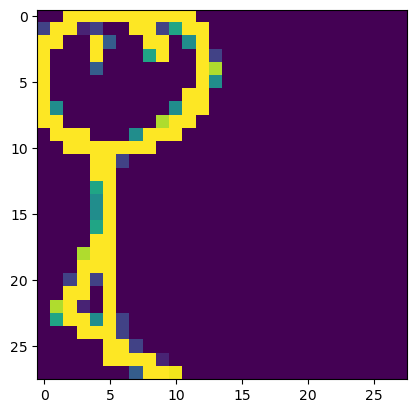

In [3]:
for x,y in dataloader:
    print(x.shape,y.shape)
    print(y)
    print(x.min(),x.max())

    image = x.detach().cpu().numpy()[0]
    image = np.reshape(image,(28,28))
    print(image)
    image = image*5.0
    image[image>=0.99]=1.0
    plt.imshow(image)

    break

    

In [4]:




ddpm = DDPM(
    nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes),
    betas=(1e-4, 0.02),
    n_T=n_T,
    device=device,
    drop_prob=0.1,
)
ddpm.to(device)

# optionally load a model
# ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))




DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 

In [5]:

# dataset = MNIST("./data", train=True, download=True, transform=tf)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)


In [6]:

optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)
scheduler = torch.optim.lr_scheduler.StepLR(optim,step_size=12,gamma=0.1)
for ep in range(n_epoch):
    print(f"epoch {ep}")
    ddpm.train()

    # linear lrate decay
    optim.param_groups[0]["lr"] = lrate * (1 - ep / n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()
    scheduler.step()
    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    ddpm.eval()
    with torch.no_grad():
        n_sample = 4 * n_classes
        for w_i, w in enumerate(ws_test):
            x_gen, x_gen_store = ddpm.sample(
                n_sample, (1, 28, 28), device, guide_w=w
            )

            # append some real images at bottom, order by class also
            x_real = torch.Tensor(x_gen.shape).to(device)
            for k in range(n_classes):
                for j in range(int(n_sample / n_classes)):
                    try:
                        idx = torch.squeeze((c == k).nonzero())[j]
                    except:
                        idx = 0
                    x_real[k + (j * n_classes)] = x[idx]

            x_all = torch.cat([x_gen, x_real])
            grid = make_grid(x_all * -1 + 1, nrow=12)
            import os

            if os.path.exists(save_dir) == False:
                os.mkdir(save_dir)
            save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
            print("saved image at " + save_dir + f"image_ep{ep}_w{w}.png")

            if ep % 5 == 0 or ep == int(n_epoch - 1):
                # create gif of images evolving over time, based on x_gen_store
                fig, axs = plt.subplots(
                    nrows=int(n_sample / n_classes),
                    ncols=n_classes,
                    sharex=True,
                    sharey=True,
                    figsize=(8, 3),
                )

                def animate_diff(i, x_gen_store):
                    print(
                        f"gif animating frame {i} of {x_gen_store.shape[0]}",
                        end="\r",
                    )
                    plots = []
                    for row in range(int(n_sample / n_classes)):
                        for col in range(n_classes):
                            axs[row, col].clear()
                            axs[row, col].set_xticks([])
                            axs[row, col].set_yticks([])
                            # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                            plots.append(
                                axs[row, col].imshow(
                                    -x_gen_store[i, (row * n_classes) + col, 0],
                                    cmap="gray",
                                    vmin=(-x_gen_store[i]).min(),
                                    vmax=(-x_gen_store[i]).max(),
                                )
                            )
                    return plots

                ani = FuncAnimation(
                    fig,
                    animate_diff,
                    fargs=[x_gen_store],
                    interval=200,
                    blit=False,
                    repeat=True,
                    frames=x_gen_store.shape[0],
                )
                ani.save(
                    save_dir + f"gif_ep{ep}_w{w}.gif",
                    dpi=100,
                    writer=PillowWriter(fps=5),
                )
                print("saved image at " + save_dir + f"gif_ep{ep}_w{w}.gif")
    # optionally save model
    if ep % 5 == 0:
        torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
        print("saved model at " + save_dir + f"model_{ep}.pth")




epoch 0


loss: 0.2519:  25%|██▍       | 58/235 [01:29<04:31,  1.53s/it]


KeyboardInterrupt: 